In [258]:
# Load the data and libraries
import pandas as pd
import numpy as np
from fontTools.misc.bezierTools import epsilon
from scipy import stats
import random
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

In [259]:
# Load the data and libraries
import pandas as pd
import numpy as np

bear = pd.read_csv('https://raw.githubusercontent.com/jbennett979/Data_Privacy_FP/refs/heads/main/north_america_bear_killings.csv')

In [260]:
#removing space from the column name age\n",
bear.columns = [c.lstrip() for c in bear]
# capitalizing columns name for age and gende
bear= bear.rename(columns={'age': 'Age'})
bear= bear.rename(columns={'gender': 'Gender'})

In [261]:
print(bear.columns)
    # converting the age column who was a string to integers
bear['Age'] = pd.to_numeric(bear['Age'], errors = 'coerce')

Index(['Name', 'Age', 'Gender', 'Date', 'Month', 'Year', 'Type', 'Location',
       'Description', 'Type of bear', 'Hunter', 'Grizzly', 'Hikers',
       'Only one killed'],
      dtype='object')


In [262]:
#
def age_sum (epsilon):
   b = 75
   clipped_sum = bear['Age'].clip(upper=b).sum()

   return (laplace_mech(clipped_sum, sensitivity=b, epsilon=epsilon))

age_sum(1.0)

np.float64(5888.276432742644)

In [263]:
def dp_avg_age(epsilon):

    noisy_sum = age_sum(epsilon/2)

    noisy_count = laplace_mech(len(bear), sensitivity=1, epsilon=epsilon/2)

    mean = noisy_sum/noisy_count

    return mean

dp_avg_age(1.0)

np.float64(35.99793872916089)

In [313]:
 # starting with choosing a clip param using clip b param for age

def pick_b_avg(epsilon):
   bs =  range(1,200,10)
   last_result = 0
   epsilon_i = epsilon / len(bs)

   for b in bs:
    #try b
    clipped_sum = bear['Age'].clip(upper=b).sum()
    noisy_sum= (laplace_mech(clipped_sum, sensitivity=b, epsilon=epsilon_i))
    noisy_count = laplace_mech(len(bear), sensitivity=1, epsilon=epsilon/2)
    result= noisy_sum / noisy_count


    if result < last_result:
        return b
    else:
        last_result = result
    #raise Exception('No good clipping parameter found')
pick_b_avg(1.0)

51

In [265]:
# differential private
def monthly_counts (epsilon):

   count= bear['Month'].value_counts()

   return (laplace_mech(count, sensitivity=1, epsilon=epsilon))

monthly_counts(1.0)

Month
8     31.255218
7     30.255218
10    27.255218
9     27.255218
6     23.255218
5     21.255218
11    15.255218
4      7.255218
1      6.255218
12     5.255218
2      4.255218
3      4.255218
Name: count, dtype: float64

In [266]:
# differential private
def year_counts (epsilon):

   count= bear['Year'].value_counts()

   return (laplace_mech(count, sensitivity=1, epsilon=epsilon))

year_counts(1.0)

Year
1980    6.926903
2005    6.926903
2018    5.926903
1983    4.926903
1992    4.926903
          ...   
1930    0.926903
1922    0.926903
1916    0.926903
1908    0.926903
1906    0.926903
Name: count, Length: 74, dtype: float64

In [267]:
# range queries
def range_query(df, col, a, b):
    return len(df[(df[col] >= a) & (df[col] < b)]) # this runs the range query

random_lower_bounds = [random.randint(1, 70) for _ in range(100)]
random_workload = [(lb, random.randint(lb, 100)) for lb in random_lower_bounds]
real_answers = [range_query(bear, 'Age', lb, ub) for (lb, ub) in random_workload]


In [268]:
def workload_laplace_vec(workload, epsilon):
    l1_sens = len(workload)
    workload_answer = [range_query(bear, 'Age', lb, ub) for (lb, ub) in random_workload]
    laplace_vec=  laplace_mech_vec(workload_answer, l1_sens, epsilon=epsilon)
    return laplace_vec
print('First 4 answers:', workload_laplace_vec(random_workload, 1.0)[:4])

First 4 answers: [111.13848395834664, 117.14058321075066, 35.391618155248096, 127.30637082420127]


In [269]:
errors_1 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(random_workload, 1.0))]
print('Average absolute error:', np.mean(errors_1))
assert np.mean(errors_1) > 20
assert np.mean(errors_1) < 150

Average absolute error: 93.02537589982144


In [270]:
# Renyi DP
def workload_gaussian_vec_RDP(workload, alpha, epsilon_bar):

    def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon):
        sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
        return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

    sensitivity = np.sqrt(len(workload))
    answers = gaussian_mech_RDP_vec([range_query(bear, 'Age', lb, ub) for (lb, ub) in workload],
                                    sensitivity, alpha, epsilon_bar)
    return answers

In [271]:
#conversion
def convert_RDP_ED(alpha, epsilon_bar, delta):
   new_epsilon = epsilon_bar + np.log(1/delta) / (alpha-1)
   return new_epsilon

convert_RDP_ED(5, 1.0, 1e-5)

np.float64(3.878231366242557)

In [272]:
#passing the converted epsilon for the average error of RDP
converted_epsilon = convert_RDP_ED(5,1.0, 1e-5)
errors_2 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec_RDP(random_workload, alpha=1.0, epsilon_bar= converted_epsilon))]
print('Average absolute error:', np.mean(errors_2))
assert np.mean(errors_2) > 1
assert np.mean(errors_2) < 100

Average absolute error: 2.8764951925329627


In [273]:
# Gaussian mech
def workload_gaussian_vec(workload, epsilon, delta):
    sensitivity = np.sqrt(len(workload))
    workload_answer = [range_query(bear, 'Age', lb, ub) for (lb, ub) in random_workload]
    gaussian_vec= gaussian_mech_vec(workload_answer, sensitivity=sensitivity, epsilon=epsilon , delta=delta)
    return gaussian_vec

In [274]:
errors_3 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(random_workload,converted_epsilon, 0.1))]
print('Average absolute error:', np.mean(errors_3))
assert np.mean(errors_3) > 1
assert np.mean(errors_3) < 100

# for renyy do the conversion , covert epsilon t
# set my epsilon bar = 1.0
# alpha to 5
# 2 set esplon to the conversion
# run both mechanisms
#rdp first and gaussian use the result of mech conversipn to do the gaussian.
# what did we learn about the data
# run on all of the columns on the loop instead of age by itself
#how epsilon on x axis , percent error on y , maybe having to show how it represents


Average absolute error: 4.429894103784837


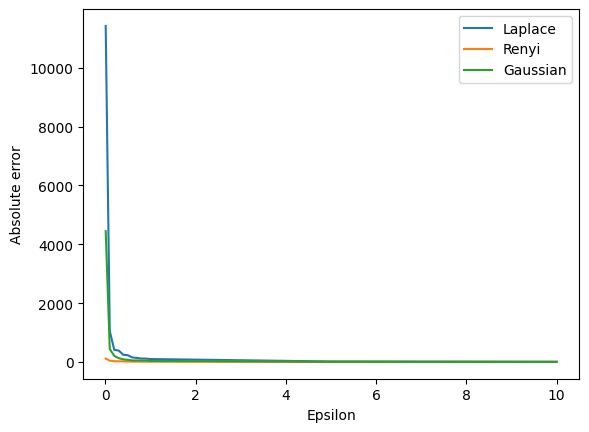

In [276]:
def graphing():
    epsilon_list = [0.01,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10.0 ]
    errors_lp = []
    errors_rdp = []
    errors_g = []
    for epsilon in epsilon_list:
        alpha = 5
    #Laplace mechanism
        errors_1 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(random_workload, epsilon))]
        errors_lp.append(np.mean(errors_1))

    # Renyi
        errors_2= [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec_RDP(random_workload, alpha=alpha, epsilon_bar=epsilon))]
        errors_rdp.append(np.mean(errors_2))

    #Gaussian
        errors_3 = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers,workload_gaussian_vec(random_workload, epsilon, delta = 1e-5))]
        errors_g.append(np.mean(errors_3))


    plt.plot(epsilon_list, errors_lp, label='Laplace')
    plt.plot(epsilon_list, errors_rdp, label='Renyi')
    plt.plot(epsilon_list, errors_g, label='Gaussian')
    plt.xlabel('Epsilon')
    plt.ylabel('Absolute error')
    plt.legend()
    plt.show()

graphing()
